## 1) Set up

In [1]:
### Set up 
import pandas as pd
import numpy as np
import re
import os
import nltk
import collections
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
import scipy.stats as stats

# Nina directory:
directory = '/Users/ninamcclure/Desktop/NLP_term_paper/moad-election-speeches/'

# Antonia directory:
#directory = '/Users/antoniageorge/Desktop/BSE_Term_2/Text_Mining/final_project/NLP_term_paper/moad-election-speeches/'

# Lenka Directory:
#directory = '/Users/lenkasefcakova/Desktop/Text_Mining/NLP_term_paper/moad-election-speeches/'

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## 2) Load and clean data

In [2]:
files = os.listdir(directory)

In [3]:
### Load data and add meta data
speeches_df = pd.DataFrame(columns = ['speech', 'year', 'name'])

for file in files:
    fname = directory + file
    speech = open(fname).read().replace('\n', ' ')
    year =  re.findall(r'\d+', file)
    name = (file.split('-')[1] + ' ' + file.split('-')[2].split('.')[0]).title()
    df = pd.DataFrame(data = {'speech': [speech], 'year': year, 'name': name})
    speeches_df = pd.concat([speeches_df, df], ignore_index=True)

speeches_df['year'] = speeches_df['year'].astype('int64')

print(speeches_df.shape)

speeches_df.head()

(93, 3)


,speech,year,name
0,Sixteen years ago today the first Federal elec...,1917,Frank Tudor
1,Three years ago I came before the people of Au...,1937,Joseph Lyons
2,"My fellow Australians, When from this place i...",1984,Bob Hawke
3,The Prime Minister (Mr. Hughes) had a rousing ...,1917,Billy Hughes
4,In this election we are now engaged in the fig...,2013,Kevin Rudd


In [4]:
### Load metadata scraped from website

#Nina:
meta = pd.read_csv('/Users/ninamcclure/Desktop/NLP_term_paper/AUS_metadata_speeches.csv')

#Antonia:
# meta = pd.read_csv('/Users/antoniageorge/Desktop/BSE_Term_2/Text_Mining/final_project/NLP_term_paper/AUS_metadata_speeches.csv')

#Lenka:
#meta = pd.read_csv('/Users/lenkasefcakova/Desktop/Text_Mining/NLP_term_paper/AUS_metadata_speeches.csv')

meta.head()

,Unnamed: 0,incumbent,elected,name,party,party_color,timeplace,year,city,date
0,0,1,0,Scott Morrison,Liberal,blue,"Delivered at Brisbane , May 15th, 2022",2022,Brisbane,2022-05-15
1,1,0,1,Anthony Albanese,Labor,blue,"Delivered at Perth , May 1st, 2022",2022,Perth,2022-05-01
2,2,1,1,Scott Morrison,Liberal,blue,"Delivered at Melbourne, May 12th, 2019",2019,Melbourne,2019-05-12
3,3,0,0,Bill Shorten,Labor,red,"Delivered at Brisbane, May 5th, 2019",2019,Brisbane,2019-05-05
4,4,1,1,Malcolm Turnbull,Liberal,blue,"Delivered at Sydney, June 26th, 2016",2016,Sydney,2016-06-26


In [5]:
### Join with speech data

speeches_df = pd.merge(speeches_df, meta, on=["year", "name"], how = 'left').sort_values(by = 'year')

speeches_df = speeches_df[(speeches_df['date'] != '1903-10-30')] # filter out blank entry

speeches_df.shape

(92, 11)

## 3) Sentiment analysis

### 3.1) Calculate 'positivity score'

In [6]:
import nltk
nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon
from tqdm import tqdm

# Load the positive and negative words from the opinion lexicon
pos_vocab = opinion_lexicon.positive()
neg_vocab = opinion_lexicon.negative()

#code breaks without the following because of special characters used in neg_vocab
neg_vocab = [re.sub(r'[^\w\s]', '', word) for word in neg_vocab]

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/ninamcclure/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [7]:
# Initialize two lists to store the count of positive and negative words
Pos_list = []
Neg_list = []
# Compile the regular expression pattern for positive words
pos = re.compile("|".join(r"\b%s\b" % w for w in pos_vocab))
# Compile the regular expression pattern for negative words
neg = re.compile("|".join(r"\b%s\b" % s for s in neg_vocab))

# Loop over each row in the corpus_data dataframe and analyze the positive sentiment
for text in tqdm(speeches_df['speech']):
        
    # Find all the positive words in the text
    wordcount = collections.Counter(re.findall(pos, text.lower()))
    # Add the count of positive words to the Pos_list
    Pos_list.append(sum(wordcount.values()))
    
    # Find all the negative words in the text
    wordcount = collections.Counter(re.findall(neg, text.lower()))
    # Add the count of negative words to the Neg_list
    Neg_list.append(sum(wordcount.values()))

# Add the Pos_list as a new column in the corpus_data dataframe
speeches_df['Pos_count'] = Pos_list
speeches_df['Neg_count'] = Neg_list

100%|██████████| 92/92 [01:54<00:00,  1.25s/it]


In [8]:
### Look at share of positive words to get a 'positivity score'

speeches_df['sentiment_score'] = speeches_df['Pos_count']/(speeches_df['Neg_count'] + speeches_df['Pos_count'])

speeches_df.head()

,speech,year,name,Unnamed: 0,incumbent,elected,party,party_color,timeplace,city,date,Pos_count,Neg_count,sentiment_score
74,1. Compliment of Hunter mainland invitation. ...,1901,Edmund Barton,92.0,1.0,1.0,Protectionist,blue,"Delivered at Maitland, NSW, January 17th, 1901",Maitland,1901-01-17,136,56,0.708333
24,The responsibilities of this occasion are such...,1903,Alfred Deakin,90.0,1.0,1.0,Protectionist,blue,"Delivered at Ballarat, Vic, October 29th, 1903",Ballarat,1903-10-29,701,282,0.713123
84,In addressing the electors of the Commonwealth...,1906,George Reid,89.0,0.0,0.0,Australian Democratic Union,blue,"Delivered at Sydney, NSW, October 23rd, 1906",Sydney,1906-10-23,529,259,0.671320
30,I appear before you as a Liberal Protectionist...,1906,Alfred Deakin,88.0,1.0,1.0,Protectionist,blue,"Delivered at Ballarat, Vic, October 17th, 1906",Ballarat,1906-10-17,268,136,0.663366
86,"The Hon. A. Fisher, Leader of the Federal Oppo...",1910,Andrew Fisher,87.0,0.0,1.0,Australian Labor,red,"Delivered at Maryborough, Qld, February 10th, ...",Maryborough,1910-02-10,48,19,0.716418


### 3.2) Results and hypothesis testing

(0.0, 12.0)

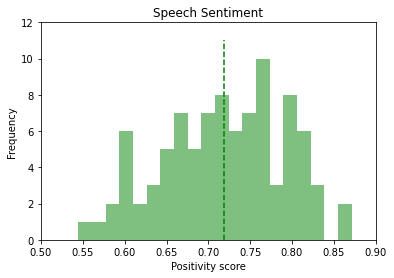

In [9]:
plt.hist(x = speeches_df['sentiment_score'], bins= 20, alpha = 0.5, label = "Right-leaning", color = 'green')
plt.vlines(speeches_df['sentiment_score'].mean(), ymin = 0, ymax = 11, linestyles = 'dashed', color = 'green')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Speech Sentiment")
plt.xlim(0.5, 0.9) 
plt.ylim(0, 12)

#### Sentiment Analysis- By Party

In [10]:
blue = speeches_df[speeches_df['party_color'] == 'blue']
red = speeches_df[speeches_df['party_color'] != 'blue']

print(blue['sentiment_score'].mean())
print(red['sentiment_score'].mean())

t_test_party = stats.ttest_ind(a=blue['sentiment_score'], b=red['sentiment_score'], equal_var=True)
t_test_party

0.7326821350256636
0.7026893643921114


Ttest_indResult(statistic=1.9761298284156474, pvalue=0.051202437879873025)

(0.0, 6.0)

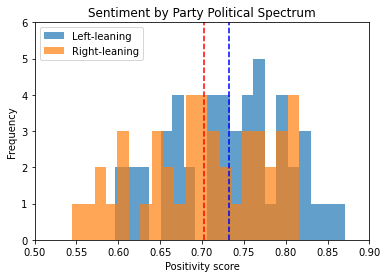

In [11]:
plt.hist(x = blue['sentiment_score'], bins= 20, alpha = 0.7, label = "Left-leaning")
plt.vlines(blue['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'blue')
plt.hist(x = red['sentiment_score'], bins= 20, alpha = 0.7, label = "Right-leaning")
plt.vlines(red['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'red')
plt.legend(loc='upper left')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Sentiment by Party Political Spectrum")
plt.xlim(0.5, 0.9) 
plt.ylim(0, 6)

#### Sentiment Analysis- Incumbent vs. Challenger

In [12]:
incumbent = speeches_df[speeches_df['incumbent'] == 1.0]
opposition = speeches_df[speeches_df['incumbent'] != 1.0]

print(incumbent['sentiment_score'].mean())
print(opposition['sentiment_score'].mean())

#perform two sample t-test 
t_test_incumbent = stats.ttest_ind(a=incumbent['sentiment_score'], b=opposition['sentiment_score'], equal_var=True)
t_test_incumbent

0.7408359342945658
0.6958395986290157


Ttest_indResult(statistic=3.051725435291589, pvalue=0.002990351323594194)

(0.5, 0.9)

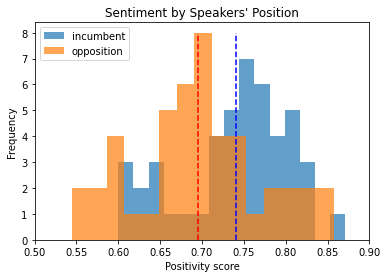

In [13]:
plt.hist(x = incumbent['sentiment_score'], bins= 15, alpha = 0.7, label = 'incumbent')
plt.vlines(incumbent['sentiment_score'].mean(), ymin = 0, ymax = 8, linestyles = 'dashed', color = 'blue')
plt.hist(x = opposition['sentiment_score'], bins= 15, alpha = 0.7, label = 'opposition')
plt.vlines(opposition['sentiment_score'].mean(), ymin = 0, ymax = 8, linestyles = 'dashed', color = 'red')
plt.legend(loc='upper left')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Sentiment by Speakers' Position")
plt.xlim(0.5, 0.9) 

#### Sentiment Analysis- Elected vs. Not Elected

In [14]:
elected = speeches_df[speeches_df['elected'] == 1.0]
not_elected = speeches_df[speeches_df['elected'] != 1.0]

print(elected['sentiment_score'].mean())
print(not_elected['sentiment_score'].mean())

#perform two sample t-test 
t_test_elected = stats.ttest_ind(a=elected['sentiment_score'], b=not_elected['sentiment_score'], equal_var=True)
t_test_elected

0.7347854020489292
0.7011591248485572


Ttest_indResult(statistic=2.229655019040475, pvalue=0.028258499096965237)

(0.0, 9.0)

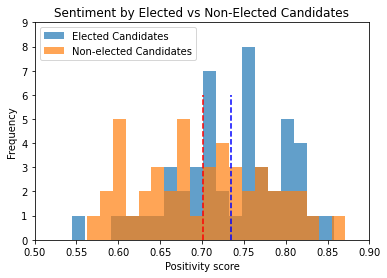

In [18]:
plt.hist(x = elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Elected Candidates")
plt.vlines(elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'blue')
plt.hist(x = not_elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Non-elected Candidates")
plt.vlines(not_elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'red')
plt.legend(loc='upper left')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Sentiment by Elected vs Non-Elected Candidates")
plt.xlim(0.5, 0.9) 
plt.ylim(0, 9)

#### Sentiment by Elected vs Non-Elected Candidates (stratified by incumbent, opposition)

In [31]:
incum_elected = incumbent[(incumbent['elected'] == 1.0)]
incum_not_elected = incumbent[incumbent['elected'] != 1.0]

opp_elected = opposition[(opposition['elected'] == 1.0)]
opp_not_elected = opposition[opposition['elected'] != 1.0]

# You can see that incumbents tend to be re-elected - in 32/46 elections the incumbent was re-elected
print(incum_elected.shape, incum_not_elected.shape,opp_elected.shape,opp_not_elected.shape)

(32, 14) (14, 14) (15, 14) (31, 14)


Ttest_indResult(statistic=1.3969845905049298, pvalue=0.169424410228838)

In [32]:
# perform two sample t-test 
t_test_incum_elected = stats.ttest_ind(a=incum_elected['sentiment_score'], b=incum_not_elected['sentiment_score'], equal_var=True)
t_test_incum_elected

# perform two sample t-test 
t_test_opp_elected = stats.ttest_ind(a=opp_elected['sentiment_score'], b=opp_not_elected['sentiment_score'], equal_var=True)
t_test_opp_elected

Ttest_indResult(statistic=0.4378915334736119, pvalue=0.6636071185966336)

(0.0, 7.0)

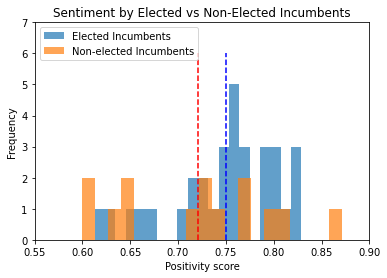

In [29]:
plt.hist(x = incum_elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Elected Incumbents")
plt.vlines(incum_elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'blue')
plt.hist(x = incum_not_elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Non-elected Incumbents")
plt.vlines(incum_not_elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'red')
plt.legend(loc='upper left')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Sentiment by Elected vs Non-Elected Incumbents")
plt.xlim(0.55, 0.9) 
plt.ylim(0, 7)

(0.0, 7.0)

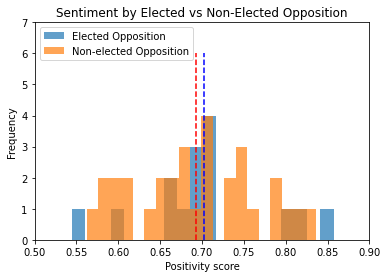

In [30]:
plt.hist(x = opp_elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Elected Opposition")
plt.vlines(opp_elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'blue')
plt.hist(x = opp_not_elected['sentiment_score'], bins= 20, alpha = 0.7, label = "Non-elected Opposition")
plt.vlines(opp_not_elected['sentiment_score'].mean(), ymin = 0, ymax = 6, linestyles = 'dashed', color = 'red')
plt.legend(loc='upper left')
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title("Sentiment by Elected vs Non-Elected Opposition")
plt.xlim(0.5, 0.9) 
plt.ylim(0, 7)

#### Sentiment over time

(0.5, 0.9)

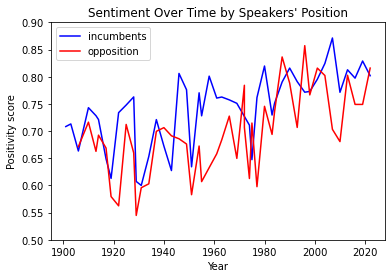

In [19]:
plt.plot(incumbent['year'], incumbent['sentiment_score'], color ='blue', label='incumbents')
plt.plot(opposition['year'], opposition['sentiment_score'], color ='red', label='opposition')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Positivity score')
plt.title("Sentiment Over Time by Speakers' Position")
plt.ylim(0.5, 0.9)

## TF IDF analysis

We will perform TFiDF analysis on different partitions of speeches namely:

- Whole Corpus
- Incumbent / Opposition
- Elected / Not-Elected
- Red / Blue party color

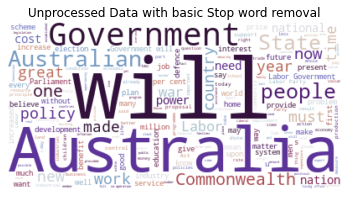

In [33]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ' '.join(speeches_df['speech'])

wordcloud = WordCloud(colormap='twilight',background_color='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Unprocessed Data with basic Stop word removal')
plt.savefig("images/unprocessed_basicstop_cloud.png",)
plt.show()

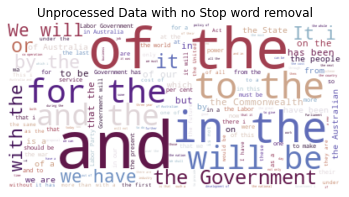

In [34]:
wordcloud = WordCloud(colormap='twilight',background_color='white',stopwords=['']).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Unprocessed Data with no Stop word removal')
plt.savefig("images/unprocessed_cloud.png",)
plt.show()

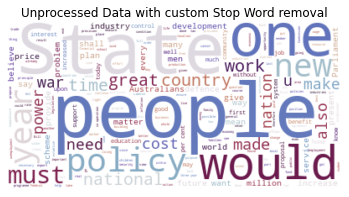

In [35]:
wordcloud = WordCloud(colormap='twilight',background_color='white',stopwords=['australia', 'government', 'prime minister', 'labor party', 
                     'commonwealth', 'australian',  'election', 'vote', 'politics',
                     'minister']+['howard','menzies','hear hear','billion','000','000 000','hear','labor','labour','parties','party']+stopwords.words('english')).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Unprocessed Data with custom Stop Word removal')
plt.savefig("images/unprocessed_stopword_dropped_cloud.png",)
plt.show()

#### Data preprocessing

We have decided to apply lemmatization on our words, stemming was also considered however the results were harder to read and retrieve meaningful findings. 

We create a pipeline to:
1. Set all words to lower case 

2. Remove stopwords 

Given the background information of our speeches and some data exploration we have added custom words to our list namely australia, government, prime minister, labor party, commonwealth, australian,  election, vote, politics, minister, howard, menzies, hear, billion, labor, parties, party.

3. Remove Punctuation

4. Lemmatization

As the dataset is relatively small we opted to apply lemmatization which enables us to work with meanings of words rather than cut the words more arbitrarily with a stemmer.

Lemmatization yields sllightly higher dimensionality of the transformer dictionary

5. Create 1 and 2 grams



In [36]:
from nltk.stem.porter import PorterStemmer
import string
from nltk.stem.snowball import SnowballStemmer

import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()


custom_stop_words = ['australia', 'government', 'prime minister', 'labor party', 
                     'commonwealth', 'australian','australians',  'election', 'vote', 'politics',
                     'minister']+['howard','menzies','hear hear','billion','hear','labor','labour','parties','party']+['policy','policies']

stemmer = SnowballStemmer(language='english')
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    tokens1 = [re.sub(r'\d+','',token) for token in tokens]
    return [stemmer.stem(item.lower()) for item in tokens1 if item.lower() not in stopwords.words('english') + custom_stop_words + [i for i in string.punctuation]+['']]

def lemmatize_tokens(tokens):
    tokens1 = [re.sub(r'\d+','',token) for token in tokens]
    return [lemmatizer.lemmatize(item.lower()) for item in tokens1 if item.lower() not in stopwords.words('english') + custom_stop_words + [i for i in string.punctuation]+['']]

'''remove punctuation, lowercase, stem'''
def stmmer(text):
    return ' '.join(stem_tokens(nltk.word_tokenize(text)))

def lmmtizer(text):
    return ' '.join(lemmatize_tokens(nltk.word_tokenize(text)))

In [37]:
# lemmatizer vs stemmer comparison
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
print("defining vectorizer")
vectorizer_lem = TfidfVectorizer(preprocessor=lmmtizer, ngram_range = (1,1))
vectorizer_stem = TfidfVectorizer(preprocessor=stmmer, ngram_range = (1,1))
print('processing speeches')
speeches = speeches_df['speech'].values.tolist()
print('fittin lemmatizer')
vectorizer_lem = vectorizer_lem.fit(speeches)
print('fittin stemmer')
vectorizer_stem = vectorizer_stem.fit(speeches)
print('transforming lemmatizer')
vectors_lem = vectorizer_lem.transform([text])
feature_names_lem = vectorizer_lem.get_feature_names()
dense_lem = vectors_lem.todense()
print('transforming stemmer')
vectors_stem = vectorizer_stem.transform([text])
feature_names_stem = vectorizer_stem.get_feature_names()
dense_stem = vectors_stem.todense()

defining vectorizer
processing speeches
fittin lemmatizer
fittin stemmer
transforming lemmatizer
transforming stemmer


In [43]:
arr_lem = np.asarray(dense_lem)[0]
dict_scores_all_lem = {feature_names_lem[i]: arr_lem[i] for i in range(len(feature_names_lem))}

arr_stem = np.asarray(dense_stem)[0]
dict_scores_all_stem = {feature_names_stem[i]: arr_stem[i] for i in range(len(feature_names_stem))}

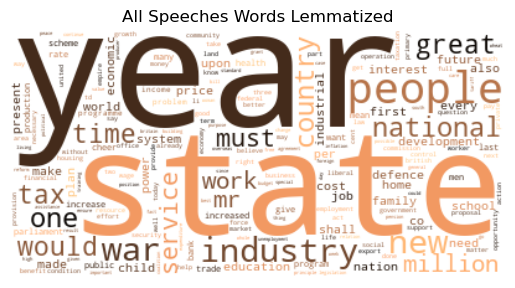

In [44]:
wordcloud = WordCloud(colormap='copper',background_color='white').generate_from_frequencies(dict_scores_all_lem)

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("All Speeches Words Lemmatized")
plt.savefig("images/all_cloud_lemmatized.png",)
plt.show()

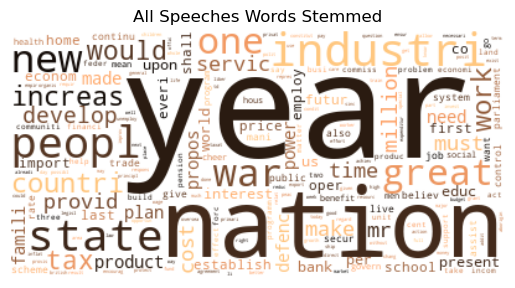

In [45]:
wordcloud = WordCloud(colormap='copper',background_color='white').generate_from_frequencies(dict_scores_all_stem)

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("All Speeches Words Stemmed")
plt.savefig("images/all_cloud_stemmed.png",)
plt.show()

In [52]:
# Fit the transformer with our preprocessing 
# 2 minutes
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=lmmtizer, max_df = 0.7, min_df = 0, ngram_range = (1,1))
speeches = speeches_df['speech'].values.tolist()
vectorizer = vectorizer.fit(speeches)
#### TF-IDF whole corpus
# approximately 3 minute comp time - whole corpus fit_transform
vectors = vectorizer.transform([text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

arr = np.asarray(dense)[0]
dict_scores_all = {feature_names[i]: arr[i] for i in range(len(feature_names))}
df_all = pd.DataFrame(dict_scores_all, index = ['Score']).transpose()
df_all['word'] = df_all.index

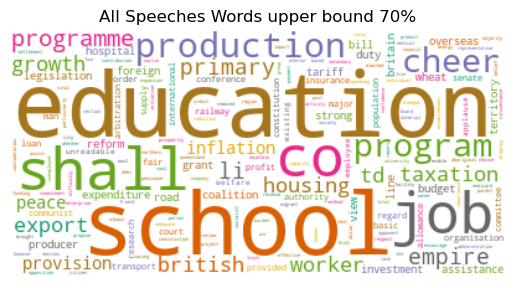

In [57]:
wordcloud = WordCloud(colormap='Dark2',background_color='white').generate_from_frequencies(dict_scores_all)

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title(r"All Speeches Words upper bound 70%")
plt.savefig("images/all_cloud_70.png",)
plt.show()

In [59]:
# Fit the transformer with our preprocessing 
# 2 minutes
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=lmmtizer, max_df = 0.7, min_df = 0.2, ngram_range = (1,1))
speeches = speeches_df['speech'].values.tolist()
vectorizer = vectorizer.fit(speeches)
#### TF-IDF whole corpus
# approximately 3 minute comp time - whole corpus fit_transform
vectors = vectorizer.transform([text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

arr = np.asarray(dense)[0]
dict_scores_all = {feature_names[i]: arr[i] for i in range(len(feature_names))}
df_all = pd.DataFrame(dict_scores_all, index = ['Score']).transpose()
df_all['word'] = df_all.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
len(feature_names)

1653

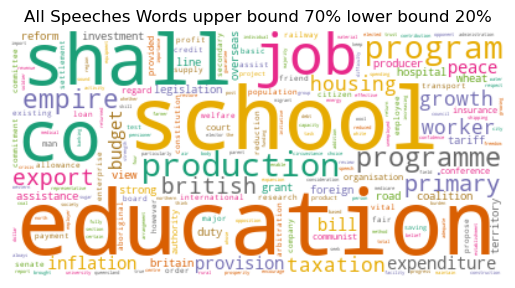

In [60]:
wordcloud = WordCloud(colormap='Dark2',background_color='white').generate_from_frequencies(dict_scores_all)

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title(r"All Speeches Words upper bound 70% lower bound 20%")
plt.savefig("images/all_cloud_70_20.png",)
plt.show()

In [62]:
# Fit the transformer with our preprocessing 
# 2 minutes
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=lmmtizer, max_df = 0.7, min_df = 0.05, ngram_range = (1,1))
speeches = speeches_df['speech'].values.tolist()
vectorizer = vectorizer.fit(speeches)
#### TF-IDF whole corpus
# approximately 3 minute comp time - whole corpus fit_transform
vectors = vectorizer.transform([text])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

arr = np.asarray(dense)[0]
dict_scores_all = {feature_names[i]: arr[i] for i in range(len(feature_names))}
df_all = pd.DataFrame(dict_scores_all, index = ['Score']).transpose()
df_all['word'] = df_all.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


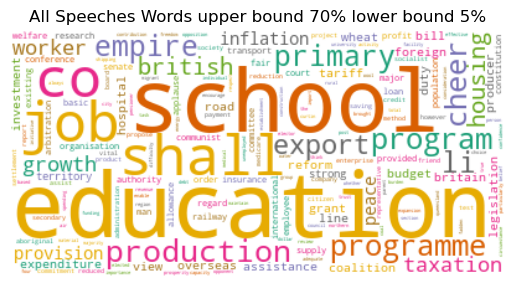

In [63]:
wordcloud = WordCloud(colormap='Dark2',background_color='white').generate_from_frequencies(dict_scores_all)

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title(r"All Speeches Words upper bound 70% lower bound 5%")
plt.savefig("images/all_cloud_70_5.png",)
plt.show()

In [64]:
len(feature_names)

4897

In [30]:
df_all.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True).head(20)

,Score,word
0,0.112361,education
1,0.106909,school
2,0.105094,shall
3,0.102858,co
4,0.101444,job
5,0.095942,production
6,0.091280,cheer
7,0.089058,program
8,0.085953,programme
9,0.077905,empire


In [31]:
# approximately 2 minute comp time 
# INCUMBENTS
speeches = ' '.join(incumbent['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_incumb = np.asarray(dense.sum(axis=0))[0]
dict_scores_incumb = {feature_names[i]: arr_incumb[i] for i in range(len(feature_names))}
df_incumb = pd.DataFrame(dict_scores_incumb, index = ['Score']).transpose()
df_incumb['word'] = df_incumb.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


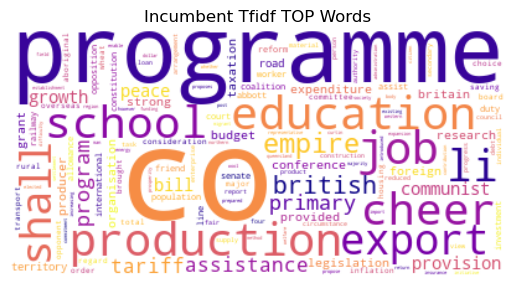

In [32]:
# Display the generated image:
wordcloud = WordCloud(colormap='plasma',background_color='white').generate_from_frequencies(dict_scores_incumb)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Incumbent Tfidf TOP Words")
#plt.savefig("images/incumbent_cloud.png",)
plt.show()

In [33]:
incumb_sorted = df_incumb.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
incumb_sorted.head(20)

,Score,word
0,0.113215,co
1,0.108992,programme
2,0.100550,production
3,0.099400,education
4,0.098271,job
5,0.093203,cheer
6,0.092544,school
7,0.086360,li
8,0.083563,export
9,0.082553,shall


In [34]:
# comp time approx 1 minutes 
speeches = ' '.join(opposition['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_opp = np.asarray(dense.sum(axis=0))[0]
dict_scores_opp = {feature_names[i]: arr_opp[i] for i in range(len(feature_names))}
df_opp = pd.DataFrame(dict_scores_opp, index = ['Score']).transpose()
df_opp['word'] = df_opp.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


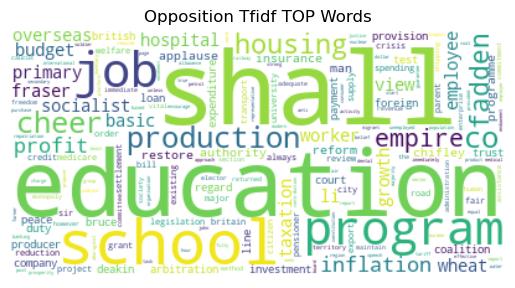

In [35]:
# Display the generated image:
wordcloud = WordCloud(colormap='viridis',background_color='white').generate_from_frequencies(dict_scores_opp)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Opposition Tfidf TOP Words")
plt.axis("off")
#plt.savefig("images/opposition_cloud.png",)
plt.show()

In [36]:
opp_sorted = df_opp.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
opp_sorted.head(20)

,Score,word
0,0.125106,shall
1,0.120792,education
2,0.117297,school
3,0.100353,program
4,0.099129,job
5,0.084898,production
6,0.084711,co
7,0.083638,cheer
8,0.081086,housing
9,0.073701,fadden


In [37]:
def get_lat(in_df,not_indf,names):
    in_not =[x for x in zip(list(in_df['Score'][:20]),list(in_df['word'][:20])) if x[1] not in list(not_indf['word'][:20])]
    not_in =[x for x in zip(list(not_indf['word'][:20]),list(not_indf['Score'][:20])) if x[0] not in list(in_df['word'][:20])]
    df_i = pd.DataFrame(in_not, columns = [names[0]+' Score', names[0]])
    df_i[names[1]] = [x[0] for x in not_in]
    df_i[names[1]+" Score"] = [x[1] for x in not_in]
    return df_i


In [38]:
a = get_lat(incumb_sorted,opp_sorted,['Incumbent','Opposition'])
print(a.to_latex(index=False))
a

\begin{tabular}{rllr}
\toprule
 Incumbent Score &  Incumbent & Opposition &  Opposition Score \\
\midrule
        0.108992 &  programme &    housing &          0.081086 \\
        0.086360 &         li &     fadden &          0.073701 \\
        0.083563 &     export &  inflation &          0.071071 \\
        0.076927 &    british &     profit &          0.070161 \\
        0.069625 &     tariff &   hospital &          0.069720 \\
        0.066623 & assistance &   taxation &          0.069401 \\
        0.064291 &  provision &      wheat &          0.068212 \\
        0.063822 &      peace &     worker &          0.067082 \\
        0.063496 &       bill &   overseas &          0.064361 \\
        0.063216 &  communist &  socialist &          0.061195 \\
\bottomrule
\end{tabular}



/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/ipykernel_24597/2412730380.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex(index=False))


,Incumbent Score,Incumbent,Opposition,Opposition Score
0,0.108992,programme,housing,0.081086
1,0.086360,li,fadden,0.073701
2,0.083563,export,inflation,0.071071
3,0.076927,british,profit,0.070161
4,0.069625,tariff,hospital,0.069720
5,0.066623,assistance,taxation,0.069401
6,0.064291,provision,wheat,0.068212
7,0.063822,peace,worker,0.067082
8,0.063496,bill,overseas,0.064361
9,0.063216,communist,socialist,0.061195


In [39]:
# comp time approx 1 min
speeches = ' '.join(blue['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_blue = np.asarray(dense.sum(axis=0))[0]
dict_scores_blue = {feature_names[i]: arr_blue[i] for i in range(len(feature_names))}
df_blue = pd.DataFrame(dict_scores_blue, index = ['Score']).transpose()
df_blue['word'] = df_blue.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


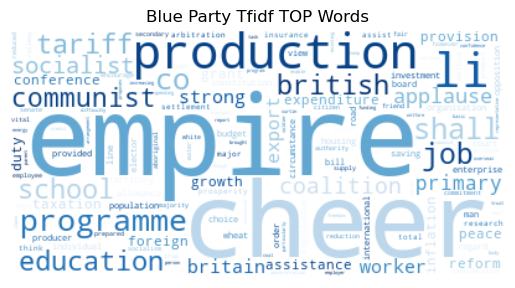

In [40]:
# Display the generated image:
wordcloud = WordCloud(colormap='Blues',background_color='white').generate_from_frequencies(dict_scores_blue)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Blue Party Tfidf TOP Words")
plt.axis("off")
#plt.savefig("images/blue_cloud.png",)
plt.show()

In [41]:
blue_sorted = df_blue.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
blue_sorted.head(20)

,Score,word
0,0.128245,empire
1,0.114761,cheer
2,0.108261,production
3,0.105096,li
4,0.104700,programme
5,0.099978,co
6,0.097965,shall
7,0.089264,job
8,0.079508,tariff
9,0.076982,british


In [42]:
speeches = ' '.join(red['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_red = np.asarray(dense.sum(axis=0))[0]
dict_scores_red = {feature_names[i]: arr_red[i] for i in range(len(feature_names))}
df_red = pd.DataFrame(dict_scores_red, index = ['Score']).transpose()
df_red['word'] = df_red.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


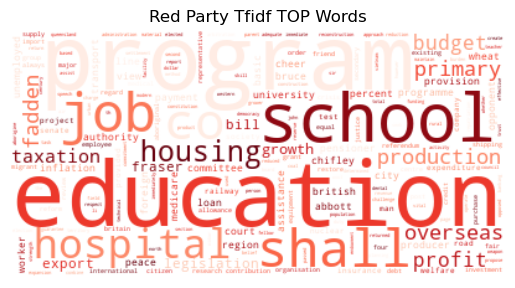

In [43]:
# Display the generated image:
wordcloud = WordCloud(colormap='Reds',background_color='white').generate_from_frequencies(dict_scores_red)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Red Party Tfidf TOP Words")
plt.axis("off")
#plt.savefig("images/red_cloud.png")
plt.show()

In [44]:
red_sorted = df_red.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
red_sorted.head(20)

,Score,word
0,0.146204,education
1,0.141436,program
2,0.136457,school
3,0.107945,job
4,0.105484,shall
5,0.098503,co
6,0.078541,hospital
7,0.076302,housing
8,0.074536,production
9,0.072461,overseas


In [45]:
a = get_lat(blue_sorted,red_sorted,['Blue','Red'])
print(a.to_latex(index=False))
a

\begin{tabular}{rllr}
\toprule
 Blue Score &      Blue &         Red &  Red Score \\
\midrule
   0.128245 &    empire &     program &   0.141436 \\
   0.114761 &     cheer &    hospital &   0.078541 \\
   0.105096 &        li &     housing &   0.076302 \\
   0.104700 & programme &    overseas &   0.072461 \\
   0.079508 &    tariff &      fadden &   0.072060 \\
   0.076982 &   british &      profit &   0.062833 \\
   0.072670 & communist &      budget &   0.062556 \\
   0.072533 & socialist &    taxation &   0.062493 \\
   0.072178 & coalition &      growth &   0.061867 \\
   0.071835 &  applause & legislation &   0.061087 \\
   0.068441 &    strong &      fraser &   0.060741 \\
   0.067761 &    worker &        bill &   0.059214 \\
\bottomrule
\end{tabular}



/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/ipykernel_24597/1305019995.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex(index=False))


,Blue Score,Blue,Red,Red Score
0,0.128245,empire,program,0.141436
1,0.114761,cheer,hospital,0.078541
2,0.105096,li,housing,0.076302
3,0.104700,programme,overseas,0.072461
4,0.079508,tariff,fadden,0.072060
5,0.076982,british,profit,0.062833
6,0.072670,communist,budget,0.062556
7,0.072533,socialist,taxation,0.062493
8,0.072178,coalition,growth,0.061867
9,0.071835,applause,legislation,0.061087


In [46]:
elected = speeches_df[speeches_df['elected'] == 1]
lost = speeches_df[speeches_df['elected'] != 1]

In [47]:
speeches = ' '.join(elected['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_elected = np.asarray(dense.sum(axis=0))[0]
dict_scores_elected= {feature_names[i]: arr_elected[i] for i in range(len(feature_names))}
df_elected = pd.DataFrame(dict_scores_elected, index = ['Score']).transpose()
df_elected['word'] = df_elected.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


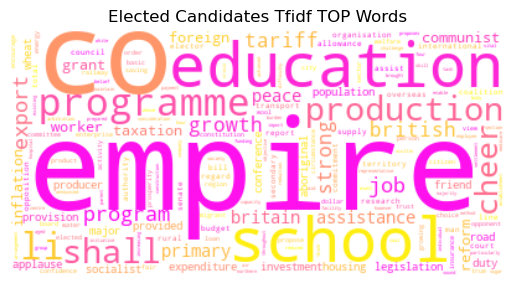

In [48]:
# Display the generated image:
wordcloud = WordCloud(colormap='spring',background_color='white').generate_from_frequencies(dict_scores_elected)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Elected Candidates Tfidf TOP Words")
plt.axis("off")
#plt.savefig("images/elected_cloud.png")
plt.show()

In [49]:
elected_sorted = df_elected.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
elected_sorted.head(20)

,Score,word
0,0.118983,empire
1,0.110821,co
2,0.109817,education
3,0.107663,school
4,0.104485,programme
5,0.100113,li
6,0.099572,production
7,0.099103,shall
8,0.082713,cheer
9,0.081240,program


In [50]:
speeches = '  '.join(lost['speech'])

vectors = vectorizer.transform([speeches])

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()

arr_lost = np.asarray(dense.sum(axis=0))[0]
dict_scores_lost= {feature_names[i]: arr_lost[i] for i in range(len(feature_names))}
df_lost = pd.DataFrame(dict_scores_lost, index = ['Score']).transpose()
df_lost['word'] = df_lost.index

/Users/lenkasefcakova/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


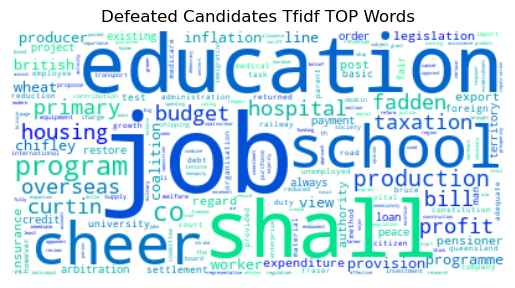

In [51]:
# Display the generated image:
wordcloud = WordCloud(colormap='winter',background_color='white').generate_from_frequencies(dict_scores_lost)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Defeated Candidates Tfidf TOP Words")
plt.axis("off")
#plt.savefig("images/lost_cloud.png")
plt.show()

In [52]:
lost_sorted = df_lost.sort_values(by = 'Score',axis =0,ascending = False).reset_index(drop=True)
lost_sorted.head(20)

,Score,word
0,0.120255,job
1,0.109547,education
2,0.106758,shall
3,0.100453,school
4,0.096729,cheer
5,0.093730,program
6,0.088036,co
7,0.086636,production
8,0.073912,primary
9,0.073057,hospital


In [53]:
a = get_lat(blue_sorted,red_sorted,['Elected','Lost'])
print(a.to_latex(index=False))
a

\begin{tabular}{rllr}
\toprule
 Elected Score &   Elected &        Lost &  Lost Score \\
\midrule
      0.128245 &    empire &     program &    0.141436 \\
      0.114761 &     cheer &    hospital &    0.078541 \\
      0.105096 &        li &     housing &    0.076302 \\
      0.104700 & programme &    overseas &    0.072461 \\
      0.079508 &    tariff &      fadden &    0.072060 \\
      0.076982 &   british &      profit &    0.062833 \\
      0.072670 & communist &      budget &    0.062556 \\
      0.072533 & socialist &    taxation &    0.062493 \\
      0.072178 & coalition &      growth &    0.061867 \\
      0.071835 &  applause & legislation &    0.061087 \\
      0.068441 &    strong &      fraser &    0.060741 \\
      0.067761 &    worker &        bill &    0.059214 \\
\bottomrule
\end{tabular}



/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/ipykernel_24597/1227617178.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex(index=False))


,Elected Score,Elected,Lost,Lost Score
0,0.128245,empire,program,0.141436
1,0.114761,cheer,hospital,0.078541
2,0.105096,li,housing,0.076302
3,0.104700,programme,overseas,0.072461
4,0.079508,tariff,fadden,0.072060
5,0.076982,british,profit,0.062833
6,0.072670,communist,budget,0.062556
7,0.072533,socialist,taxation,0.062493
8,0.072178,coalition,growth,0.061867
9,0.071835,applause,legislation,0.061087
